In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

data = pd.read_csv('diabetes.csv')

data.drop('DiabetesPedigreeFunction', axis=1, inplace=True)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
0,6,148,72,35,0,33.6,50,1
1,1,85,66,29,0,26.6,31,0
2,8,183,64,0,0,23.3,32,1
3,1,89,66,23,94,28.1,21,0
4,0,137,40,35,168,43.1,33,1


## Unidades de los datos
Sumamente importante pues no viene incluida como metadata en el archivo de datos, esto es de acuerdo a la pagina en que fueron obtenidos:

- Pregnancies: Cantidad de embarazos
- Glucose: Concentración de glucosa en plasma $mg/dL$
- BloodPressure: Presión distolica $mm Hg$
- SkinThickness: Triceps skin fold thickness $mm$
- Insulin: Insulina en $u U / mL$
- BMI: Indice de Masa Corporal $\frac{Kg}{m^2}$
- Age: Edad en años
- Outcome: 1 para diabetes, 0 para no diabetes

# Diabetes


## Limpieza de Datos

In [50]:
# al ver los histogramas se notó que existen BMI's menores a 10
data[data.BMI < 10][:5]
# son 0, lo que significa que no son BMI's correctos, pero producto de error

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
9,8,125,96,0,0,0.0,54,1
49,7,105,0,0,0,0.0,24,0
60,2,84,0,0,0,0.0,21,0
81,2,74,0,0,0,0.0,22,0
145,0,102,75,23,0,0.0,21,0


In [51]:
# Tambien glucosa 0
# donde <117mmg/dL es no diabetico
# pero se observan de igual forma diabeticos
# podria ser indicativo de tener datos erroneos asi que tambien se limpiaran
data[data.Glucose< 10][:5]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
75,1,0,48,20,0,24.7,22,0
182,1,0,74,20,23,27.7,21,0
342,1,0,68,35,0,32.0,22,0
349,5,0,80,32,0,41.0,37,1
502,6,0,68,41,0,39.0,41,1


In [52]:
# Lo mismo ocurrira con la insulina
# asi que limpiamos:

data.drop(data[data.BMI == 0].index, inplace=True)
data.drop(data[data.Glucose == 0].index, inplace=True)
data.drop(data[data.Insulin == 0].index, inplace=True)



## Visualizacion de los dato y Correlaciones

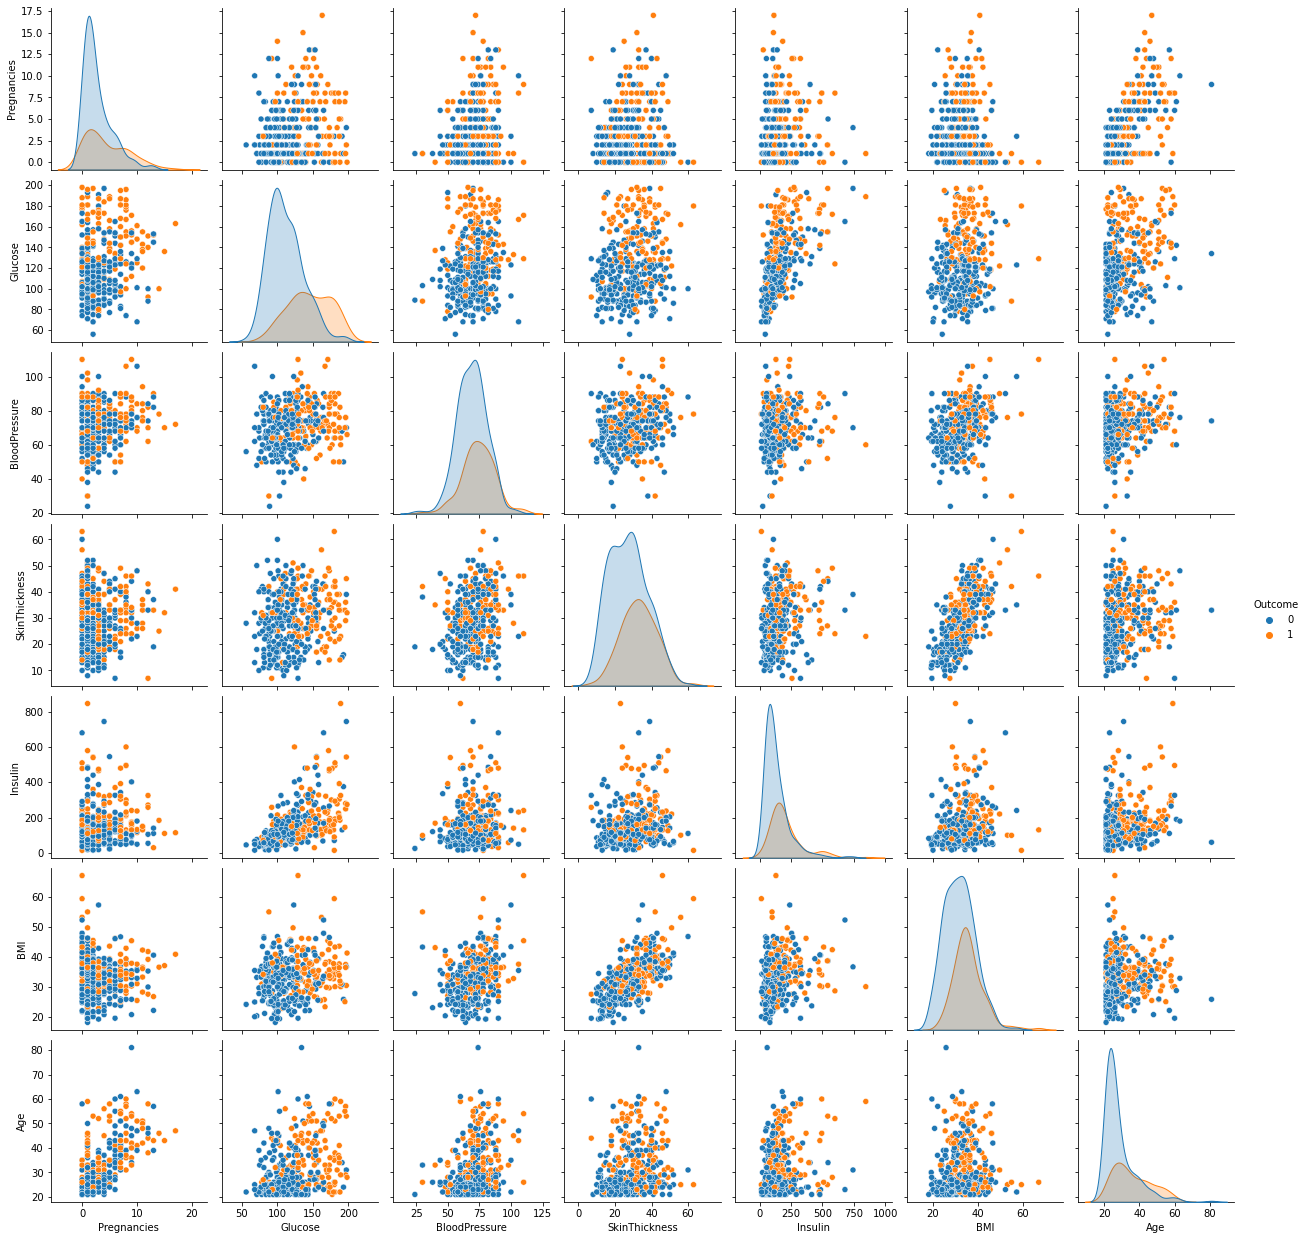

In [53]:
sns.pairplot(data, hue="Outcome")

La visualización de los datos guia la exploración del analista de los datos;
en este caso es posible observar 2 tendencias en las distribuciones (las columnas centrales que presentan los histogramas)
- La glucosa para los diabeticos se encuentra distribuida hacia la derecha
- El BMI para los diabeticos se encuentra distribuido hacia la derecha

Por tanto para comprobar si es una diferencia significativa, se realizara un test de hipotesis no parametrico llamado `Kruskal-Wallis`:

```
Test de la hipotesis nula que las medias de los grupos son iguales (funciona con más de 2 grupos)
Rechazar la hipotesis no indica cual de las muestras difiere
Tampoco entrega información a si es debido a la dispersión de los grupos o en verdad a una media poblacional distinta
```

[1]
W. H. Kruskal & W. W. Wallis, “Use of Ranks in One-Criterion Variance Analysis”, Journal of the American Statistical Association, Vol. 47, Issue 260, pp. 583-621, 1952.

[2]
https://en.wikipedia.org/wiki/Kruskal-Wallis_one-way_analysis_of_variance

In [54]:
from scipy import stats

grupo_no_diabetes = data[data['Outcome']==0]
grupo_diabetes = data[data['Outcome']==1]

In [55]:
def kruskal_wallis_median_test(grupo1, grupo2, variable, explain=True):
    """ Funcion que ordena la respuesta para el test de kruskal wallis"""

    if explain:
        print(f"Hipotesis Nula H0: Las medias de {variable} para los grupos de diabeticos y no diabeticos son iguales")
        print("Hipotesis Alternativa: Las medias de los grupos difieren.")

    p_value = stats.kruskal(grupo_diabetes[variable], grupo_no_diabetes[variable]).pvalue

    if p_value < 0.05:
        print("Tenemos evidencia contra la hipotesis nula")
        print(f"Test KW encuentra una diferencia significativa (p={p_value})")
        print(f"Indicando una diferencia de las medias de la {variable} para los dos grupos")
    elif p_value >= 0.05:
        print("No hay evidencia contra la hipotesis nula")
        print("Por tanto no podemos afirmar que existe evidencia significativa entre")
        print(f"Las medias de los grupos para la variable {variable}")
        print(f"p = {p_value}")

---Glucosa---
Hipotesis Nula H0: Las medias de Glucose para los grupos de diabeticos y no diabeticos son iguales
Hipotesis Alternativa: Las medias de los grupos difieren.
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=6.099204122037835e-23)
Indicando una diferencia de las medias de la Glucose para los dos grupos


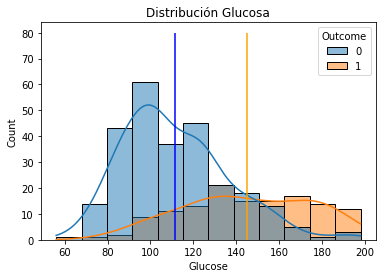

In [56]:
print("---Glucosa---")
kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, 'Glucose')

sns.histplot(data, x='Glucose', kde=True, hue='Outcome')

plt.vlines(grupo_diabetes.mean().Glucose, 0, 80, color='orange',label='media diabeticos')
plt.vlines(grupo_no_diabetes.mean().Glucose, 0, 80, color='blue', label='media NO diabeticos')

plt.title("Distribución Glucosa")
plt.show()

---BMI---
Hipotesis Nula H0: Las medias de BMI para los grupos de diabeticos y no diabeticos son iguales
Hipotesis Alternativa: Las medias de los grupos difieren.
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=1.2840414429633036e-07)
Indicando una diferencia de las medias de la BMI para los dos grupos


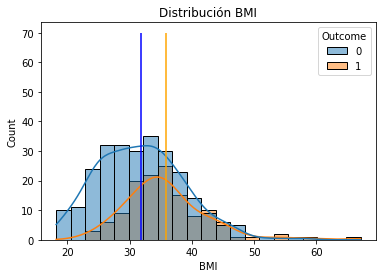

In [57]:
print("---BMI---")
kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, 'BMI')

sns.histplot(data, x='BMI', kde=True, hue='Outcome')

plt.vlines(grupo_diabetes.mean().BMI, 0, 70, color='orange',label='media diabeticos')
plt.vlines(grupo_no_diabetes.mean().BMI, 0, 70, color='blue', label='media NO diabeticos')

plt.title("Distribución BMI")
plt.show()

el BMI juega un rol importante para la clasificación;
puede observarse en articulos como:

[3] 
Yoo, B., Nam, H., In Koo Hwang, & Park, Y.-M. (2017). Correlation of Cardiovascular Risk Factors with Central Obesity and Multiple Body Mass Index in Korea. 38(6), 338–338. https://doi.org/10.4082/kjfm.2017.38.6.338

Donde se observa una correlación del BMI con enfermedades cardiovasculares, sindrome metabolico y diabetes
‌

In [58]:
# Y ahora el resto de las variables:
for variable_test in ['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'Age']:
    print(f"---{variable_test}----")
    kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, variable_test, explain=False)
    print("-------------------------------------------------------------------")


---Pregnancies----
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=7.51445944419909e-05)
Indicando una diferencia de las medias de la Pregnancies para los dos grupos
-------------------------------------------------------------------
---BloodPressure----
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=8.939814063426113e-05)
Indicando una diferencia de las medias de la BloodPressure para los dos grupos
-------------------------------------------------------------------
---SkinThickness----
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=2.686615409444294e-07)
Indicando una diferencia de las medias de la SkinThickness para los dos grupos
-------------------------------------------------------------------
---Insulin----
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=1.2113898297102416e-13)
Indicando una diferen

Luego de este analisis se nota algo interesante;
y es que existe muchas diferencias para las medias de los grupos;
sin embargo no existe una diferencia para la `Insulina`

---Insulina---
Hipotesis Nula H0: Las medias de Insulin para los grupos de diabeticos y no diabeticos son iguales
Hipotesis Alternativa: Las medias de los grupos difieren.
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=1.2113898297102416e-13)
Indicando una diferencia de las medias de la Insulin para los dos grupos


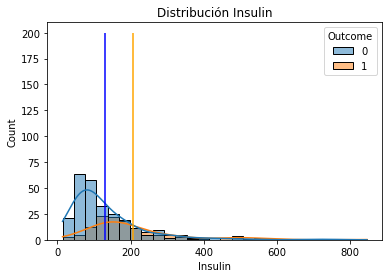

In [59]:
print("---Insulina---")
kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, 'Insulin')

sns.histplot(data, x='Insulin', kde=True, hue='Outcome')

plt.vlines(grupo_diabetes.mean().Insulin, 0, 200, color='orange',label='media diabeticos')
plt.vlines(grupo_no_diabetes.mean().Insulin, 0, 200, color='blue', label='media NO diabeticos')

plt.title("Distribución Insulin")
plt.show()

Existe una diferencia visible en la distribución, pero debido a la distribución de los datos u otros factores como la dispersión podria ser opacada.
Se apoyo en la literatura para expandir más los conocimientos del area:

[4]
CDC. (2023, February 28). Diabetes Tests. Centers for Disease Control and Prevention. https://www.cdc.gov/diabetes/basics/getting-tested.html#:~:text=A%20fasting%20blood%20sugar%20level,higher%20indicates%20you%20have%20diabetes.

Tambien se exploró el uso de otros indices, como los de [5] que se apoyan en los triliceridos y el HDL (high density lipoprotein)

[5]
Ortiz, J., & Franco Romaní. (2018). Índice triglicéridos/colesterol de alta densidad y perfil lipídico en adolescentes escolares de una región andina del Perú. https://doi.org/10.15381/anales.v79i4.15634

‌[6]
Índice triglicéridos/HDL-colesterol: en una población de adolescentes sin factores de riesgo cardiovascular. (2020). Alanrevista.org. https://www.alanrevista.org/ediciones/2012/2/art-10/

‌[7]
Sujatha, R., & Kavitha, S. (2017). Atherogenic indices in stroke patients: A retrospective study. Iranian Journal of Neurology, 16(2), 78–82. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5526781/

‌[8]
N Fernando Carrasco, Galgani, E., & J. Marcela Reyes. (2013). Síndrome de resistencia a la insulina. estudio y manejo. 24(5), 827–837. https://doi.org/10.1016/s0716-8640(13)70230-x

‌[9]
Bonora, E., Kiechl, S., Johann Willeit, Friedrich Oberhollenzer, Egger, G., Targher, G., Alberiche, M., Bonadonna, R. C., & Muggeo, M. (1998). Prevalence of insulin resistance in metabolic disorders: the Bruneck Study. 47(10), 1643–1649. https://doi.org/10.2337/diabetes.47.10.1643

‌
‌

Entre la literatura aparece el indice `HOMA-IR`
de acuerdo a [8] 

"Por su simplicidad y buena correlación con mediciones más complejas de sensibilidad a la insulina, el método más utilizado es el cálculo del índice HOMA-IR (Homeostasis Model Assessment of Insulin Resistance)"

$$
\text{HOMA-IR} = \frac{\text{Glucosa} [mg/dL] \times \text{Insulina} [uU/mL]}{405}
$$

el punto de corte para definir resistencia a la insulina fue definido por Bonora et al [9] (1998) como 2.77
Sin embargo este dependerá de la población en estudio, por ejemplo en Chile el indice de corte se encontraria alrededor de 2.5 con la definición de [9]


In [60]:
# Agregando el indice a los datos
data['HOMAIR'] = data['Glucose'] * data['Insulin'] / 405

Llegamos así al punto en donde tenemos los datos limpios y aumentados;
por tanto se guardaran en un CSV aparte

In [62]:
data.to_csv('diabetes_clean.csv')

### PCA | Data Segmentation Hypothesis
Existe una posible segmentación en los datos en base a PCA con las variables:
- Edad
- BMI
- Pregnancies



In [63]:
def PCA_KNN(X,y,name,n_neighbors):
    # Split de train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42
    )

    # Reduce dimension to 2 with PCA
    pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=42))
    pca.fit(X_train, y_train);

    # KNN
    knn = KNeighborsClassifier(n_neighbors=n_neighbors);

    # KKN fit
    knn.fit(pca.transform(X_train), y_train)
    # accurarcy del KNearestN
    acc_knn = knn.score(pca.transform(X_test), y_test)

    # Transformacion a 2D
    X_embedded = pca.transform(X)

    sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.colorbar(sc)
    plt.title(
        "{}\nTest accuracy = {:.2f}".format(name,acc_knn)
        )
    plt.show()

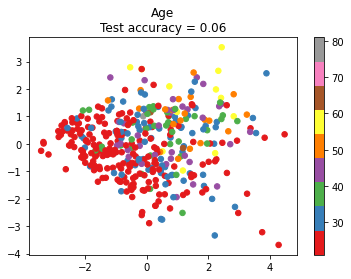

In [64]:
# Edad
X, y = data.loc[:,:'BMI'], data['Age']
PCA_KNN(X,y,name='Age',n_neighbors=2)


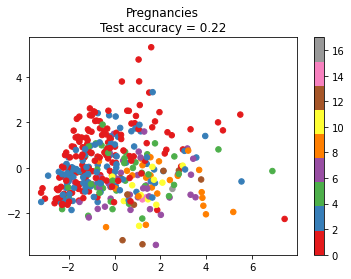

In [65]:
# Pregnancies
X, y = data.drop(['Outcome'], axis=1), data['Pregnancies']
PCA_KNN(X,y,name='Pregnancies',n_neighbors=2)


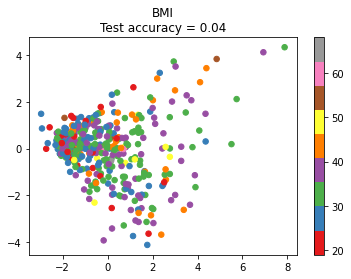

In [67]:
# BMI
X, y = data.drop(['Outcome','BMI'], axis=1), np.ceil(data['BMI'].values)
PCA_KNN(X,y,name='BMI',n_neighbors=2)


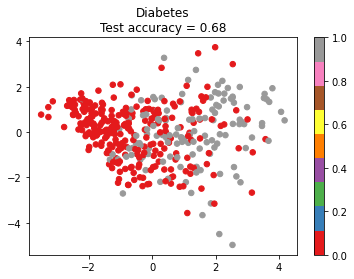

In [68]:
# Diabetes
X, y = data.loc[:,:'Age'], data['Outcome']
PCA_KNN(X,y,name='Diabetes',n_neighbors=2)

# existe una segmentación de datos bastante buena para el diabetes

Conclusión:
No hay una segmentación directa mediante las variables por si solas en el contexto de un PCA en 2 dimensiones
- Age
- BMI
- Pregnancies

Sin embargo el PCA provee un buen primer intento para identificar el diabetes, logrando una precisión por encima del 60%. Por lo que arroja esperanza a poder realizar un identificador más poderoso.

### Hipotesis 2:
Es posible identificar o separar los datos de diabeticos con una precisión mayor del 60% utilizando unicamente en combinación
- Age
- BMI
- Pregnancies


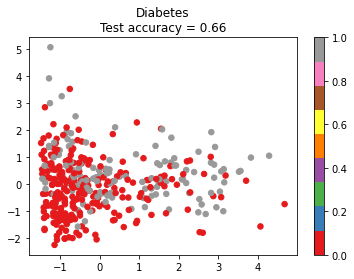

In [69]:
# Diabetes
X, y = data[['Age','BMI','Pregnancies']], data['Outcome']
PCA_KNN(X,y,name='Diabetes',n_neighbors=2)

Conclusión: Utilizando unicamente las variables visuales es posible predecir la diabetes con un 60%; es una precisión baja y podria ser producto de estar trabajando unicamente con el BMI como un indicador

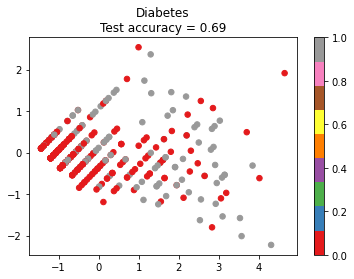

In [70]:
# Diabetes
X, y = data[['Age','Pregnancies']], data['Outcome']
PCA_KNN(X,y,name='Diabetes',n_neighbors=2)

descontar el BMI produce un resultado similar al 60%.

El uso de estos test funcionan para ver si existe algun indicador poderoso a simple vista que no requiera de la artilleria pesada de la computación.

Usar las 3 variables visibles como primer indicador podria resultar siendo un buen inicio.

# Neural Networks

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

data = pd.read_csv('diabetes_clean.csv', index_col=0)

print(len(data))
data.head()

392


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome,HOMAIR
3,1,89,66,23,94,28.1,21,0,20.656790
4,0,137,40,35,168,43.1,33,1,56.829630
6,3,78,50,32,88,31.0,26,1,16.948148
8,2,197,70,45,543,30.5,53,1,264.125926
13,1,189,60,23,846,30.1,59,1,394.800000


In [74]:
import torch.nn as nn
import torch

from torch.optim import SGD, Adam
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.init as init

from sklearn.preprocessing import normalize

Las técnicas de normalización se utilizan para escalar y transformar las características (variables) de un conjunto de datos con el objetivo de que todas las características tengan la misma escala o distribución. Esto es útil para evitar que una característica domine sobre las demás debido a su rango o magnitud.

- The maximum absolute scaling: Esta técnica escala los valores de las características al dividir cada valor por el máximo valor absoluto encontrado en el conjunto de datos. Esto asegura que todos los valores estén en el rango de -1 a 1. Es una técnica útil cuando se desea mantener la relación de magnitud entre las características, pero se elimina la información sobre la distribución original.

- The min-max feature scaling: En esta técnica, los valores de las características se escalan al rango específico, generalmente entre 0 y 1. Se calcula restando el valor mínimo de cada característica y dividiendo por la diferencia entre el valor máximo y el valor mínimo. Esta técnica preserva la relación de magnitud y la distribución relativa de los datos originales.

- The z-score method: Esta técnica también se conoce como estandarización. Se basa en la transformación de los valores de las características para que tengan una media cero y una desviación estándar de uno. Para lograr esto, se resta la media de cada característica y se divide por su desviación estándar. La estandarización es útil cuando se desea que los datos tengan una distribución normal con media cero y varianza uno.

- The robust scaling: Esta técnica está diseñada para manejar datos con valores atípicos (outliers). Utiliza una mediana y una medida de dispersión robusta, como el rango intercuartil (IQR), en lugar de la media y la desviación estándar. Los valores se escalan restando la mediana y dividiendo por el IQR. Esto hace que la técnica sea más resistente a los valores atípicos y adecuada para conjuntos de datos con distribuciones no normales.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Min Max Scaler
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Max Abs Scaler
abs_scaler = MaxAbsScaler()
abs_scaler.fit(data)
scaled_data = abs_scaler.transform(data)
df_scaled = pd.DataFrame(scaled_data, columns=data.columns)

# Standard Scaler
std_scaler = StandardScaler()
df_std = pd.DataFrame(std_scaler.fit_transform(data), columns=data.columns)

# Robust Scaler
scaler = RobustScaler()
df_robust = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)



In [76]:
X, y = data.drop(['Outcome'], axis=1), data['Outcome']

In [ ]:
# normalizar los datos
Xn = normalize(X, axis=0) 

In [15]:
# Separar los datos
Xn, y = torch.Tensor(Xn), torch.Tensor(y)
X_train, X_test, y_train, y_test = train_test_split(
    Xn, y, test_size=0.8, random_state=42
    )

Text(0.5, 1.0, 'Funcion activacion: LeakyReLU')

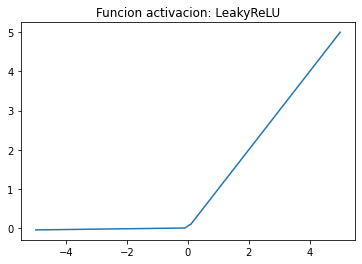

In [109]:
x = torch.linspace(-5,5,50)
lrelu = nn.LeakyReLU()
plt.plot(x, lrelu(x))
plt.title("Funcion activacion: LeakyReLU")

Text(0.5, 1.0, 'Sigmoide -> Probabilidad')

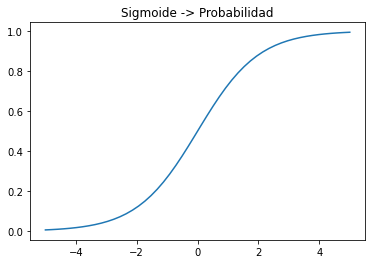

In [108]:
x = torch.linspace(-5,5,50)
sigmoid = nn.Sigmoid()
plt.plot(x, sigmoid(x))
plt.title("Sigmoide -> Probabilidad")

In [41]:

class CompleteNetwork(nn.Module):
    def __init__(self, input_size, max_depth, width_multiplier=3):
        super(CompleteNetwork, self).__init__()
        
        self.input_size = input_size
        self.max_depth = max_depth
        self.size = input_size*width_multiplier

        funcion_activacion_1 = nn.PReLU()
        funcion_activacion_2 = nn.Tanh()

        # Construcción de las capas
        layers = []

        layer = nn.Linear(self.input_size, self.size)
        init.xavier_uniform_(layer.weight)  # Inicialización de Xavier
        layers.append(layer)
        layers.append(funcion_activacion_1)
        
        # Se expanden
        depth = max_depth//2
        for i in range(1,depth+1):
            layer = nn.Linear(self.size * i, self.size * (i + 1))
            init.xavier_uniform_(layer.weight)  # Inicialización de Xavier
            layers.append(layer)
            layers.append(funcion_activacion_1)


        for i in range(depth,0,-1):
            layer = nn.Linear(self.size * (i+1), self.size * (i))
            init.xavier_uniform_(layer.weight)  # Inicialización de Xavier
            layers.append(layer)
            layers.append(funcion_activacion_2)

        
        # hasta acabar con solo una sigmoide
        layer = nn.Linear( self.size * (i),1)
        init.xavier_uniform_(layer.weight)  # Inicialización de Xavier
        layers.append(layer)
        # layers.append( nn.Linear(self.input_size,1))
        layers.append(nn.Sigmoid())


        self.layers = nn.Sequential(*layers)

    def forward(self, X):
        return self.layers(X)
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    

In [42]:
model = CompleteNetwork(input_size=X_train.shape[1], 
     max_depth=2, width_multiplier=2)

# Obtener el número total de parámetros
total_params = count_parameters(model)
print("Número total de parámetros: ", total_params)

model

Número total de parámetros:  954


CompleteNetwork(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=14, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=14, out_features=28, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=28, out_features=14, bias=True)
    (5): Tanh()
    (6): Linear(in_features=14, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [43]:
model(X_train)

tensor([[0.5051],
        [0.5057],
        [0.5058],
        [0.5069],
        [0.5050],
        [0.5043],
        [0.5044],
        [0.5033],
        [0.5046],
        [0.5037],
        [0.5099],
        [0.5037],
        [0.5055],
        [0.5070],
        [0.5039],
        [0.5049],
        [0.5058],
        [0.5041],
        [0.5060],
        [0.5052],
        [0.5038],
        [0.5049],
        [0.5057],
        [0.5040],
        [0.5045],
        [0.5068],
        [0.5051],
        [0.5042],
        [0.5033],
        [0.5058],
        [0.5051],
        [0.5038],
        [0.5038],
        [0.5071],
        [0.5056],
        [0.5060],
        [0.5045],
        [0.5033],
        [0.5056],
        [0.5041],
        [0.5041],
        [0.5030],
        [0.5036],
        [0.5038],
        [0.5039],
        [0.5038],
        [0.5041],
        [0.5040],
        [0.5045],
        [0.5025],
        [0.5043],
        [0.5030],
        [0.5059],
        [0.5023],
        [0.5038],
        [0

In [55]:
lr = 0.0001

# Binary Cross Entropy
# La entropia mide la incertidumbre
# muy util para resultados binarios
loss_fn   = nn.BCELoss()  
optimizer = Adam(model.parameters(), lr=lr)
 
# el scheduler se encarga de tener un learning rate que varia ciclicamente
# de manera que permite pegar grandes saltos asi como ser muy pequeño
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=30)


In [61]:
n_epochs = 500
batch_size = 10

In [58]:
loss_array_training = []
loss_array_testing = []

In [62]:
 for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y_train[i:i+batch_size].reshape(-1,1)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # extraer la perdida registrada

    loss_array_training.append(loss.detach())

    with torch.no_grad():
        y_pred = model(X_test)
        loss = loss_fn(y_pred, y_test.reshape(-1,1))
        loss_array_testing.append(loss.detach())


    # actualiza Learning Rate
    scheduler.step()
    
    if epoch % 5 == 0:
        print(f'epoch {epoch}, point loss {loss}')
 

epoch 0, point loss 0.6445692181587219
epoch 5, point loss 0.6444718837738037
epoch 10, point loss 0.6443718075752258
epoch 15, point loss 0.6442699432373047
epoch 20, point loss 0.6441665291786194
epoch 25, point loss 0.6440620422363281
epoch 30, point loss 0.6439561247825623
epoch 35, point loss 0.6438482403755188
epoch 40, point loss 0.643738329410553
epoch 45, point loss 0.6436255574226379
epoch 50, point loss 0.6435128450393677
epoch 55, point loss 0.6433969140052795
epoch 60, point loss 0.6432811617851257
epoch 65, point loss 0.6431611776351929
epoch 70, point loss 0.6430347561836243
epoch 75, point loss 0.6429033875465393
epoch 80, point loss 0.6427702903747559
epoch 85, point loss 0.642635703086853
epoch 90, point loss 0.6424967050552368
epoch 95, point loss 0.6423560380935669
epoch 100, point loss 0.6422133445739746
epoch 105, point loss 0.6420683860778809
epoch 110, point loss 0.6419209837913513
epoch 115, point loss 0.6417701840400696
epoch 120, point loss 0.6416146159172058

Accuracy 0.6585366129875183


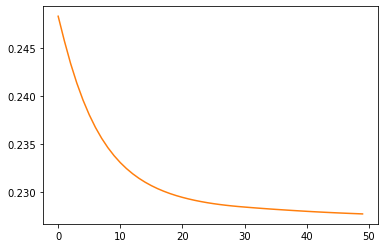

In [48]:
# Evolución del Loss en el training
plt.plot(loss_array_training)
plt.plot(loss_array_testing)

model.eval();
X_test = torch.Tensor(X_test)

# Precisión del Modelo para Datos No Vistos
y_pred = model(X_test)
accuracy = (y_pred.round() == y_test).float().mean()
print(f"Accuracy {accuracy}")

In [64]:
model(X_test)

tensor([[0.4483],
        [0.3476],
        [0.3461],
        [0.4064],
        [0.4064],
        [0.4482],
        [0.3428],
        [0.3611],
        [0.4173],
        [0.3976],
        [0.4417],
        [0.4261],
        [0.4683],
        [0.3954],
        [0.3464],
        [0.3925],
        [0.3533],
        [0.3905],
        [0.4256],
        [0.3742],
        [0.3783],
        [0.3443],
        [0.4850],
        [0.3547],
        [0.4824],
        [0.4302],
        [0.3934],
        [0.3341],
        [0.3749],
        [0.3710],
        [0.3782],
        [0.3890],
        [0.4672],
        [0.3741],
        [0.3477],
        [0.4881],
        [0.3900],
        [0.3204],
        [0.4691],
        [0.3683],
        [0.3765],
        [0.3533],
        [0.3883],
        [0.4753],
        [0.3681],
        [0.4339],
        [0.4319],
        [0.3800],
        [0.4160],
        [0.4227],
        [0.3612],
        [0.4806],
        [0.5608],
        [0.3511],
        [0.3804],
        [0

In [63]:
model(X_test) - y_test.reshape(-1,1)

tensor([[ 0.4483],
        [ 0.3476],
        [ 0.3461],
        [ 0.4064],
        [ 0.4064],
        [ 0.4482],
        [ 0.3428],
        [ 0.3611],
        [ 0.4173],
        [ 0.3976],
        [-0.5583],
        [ 0.4261],
        [-0.5317],
        [ 0.3954],
        [ 0.3464],
        [-0.6075],
        [ 0.3533],
        [ 0.3905],
        [-0.5744],
        [-0.6258],
        [ 0.3783],
        [ 0.3443],
        [ 0.4850],
        [ 0.3547],
        [ 0.4824],
        [-0.5698],
        [ 0.3934],
        [ 0.3341],
        [-0.6251],
        [ 0.3710],
        [-0.6218],
        [-0.6110],
        [-0.5328],
        [-0.6259],
        [ 0.3477],
        [-0.5119],
        [-0.6100],
        [-0.6796],
        [ 0.4691],
        [-0.6317],
        [ 0.3765],
        [ 0.3533],
        [ 0.3883],
        [-0.5247],
        [ 0.3681],
        [-0.5661],
        [-0.5681],
        [ 0.3800],
        [ 0.4160],
        [ 0.4227],
        [ 0.3612],
        [-0.5194],
        [-0.